In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import lsqr
from scipy.optimize import least_squares
import datetime as dt
from scipy.integrate import trapezoid, simpson
from scipy.optimize import curve_fit
from scipy import signal

In [23]:
load_fake_data = False

In [24]:
if (load_fake_data == True):
    rootdir = 'data_withalloffsets_b/scizone1b_nooffset/'
    init_points = 0
    err_idx = []

else:
    rootdir = '20220114_20220115_data/20220114_2326_2333/'
    init_points = 30
    err_idx = [1020, 1045]

In [25]:
igrf_dat_dir = rootdir + 'elx_bt89_gei.txt'
att_dat_dir = rootdir + 'elx_att_gei.txt'

if (load_fake_data == True):
    fgmc_dat_dir = rootdir + 'elx_bt89_fgmc.txt'
else:
    fgmc_dat_dir = rootdir + 'elx_fgs.txt'
    
dmxl_dat_dir = rootdir + 'elx_bt89_dmxl.txt'

In [26]:
igrf_data = np.loadtxt(igrf_dat_dir, dtype=str)
att_data = np.loadtxt(att_dat_dir, dtype=str)
fgmc_data = np.loadtxt(fgmc_dat_dir, dtype=str)
dmxl_data = np.loadtxt(dmxl_dat_dir, dtype=str)

In [27]:
times = list(fgmc_data[:,0])
times = [t.replace('/', ' ') for t in times]
data = pd.DataFrame(times, columns = ['Time (Full)'])
data['Time (Full)'] = pd.to_datetime(data['Time (Full)'])
data['Time (Full)'] = data['Time (Full)']-data['Time (Full)'][0]
data['ctime'] = data['Time (Full)'].dt.total_seconds()
data = data.drop('Time (Full)', axis=1)
ctime = np.array(data['ctime'])

In [28]:
if(len(err_idx)!=0):

    mid_idx = [i for i in range(err_idx[0]+1, err_idx[1])]
    shift_idx = [i for i in range(err_idx[0], err_idx[1]+1)]
    shift = np.median(np.abs((ctime[1:]-ctime[:-1])[err_idx] - np.median(ctime[mid_idx][1:]-ctime[mid_idx][:-1])))
    shift_idx_act = [i for i in range(err_idx[0]+1, err_idx[1]+1)]
    ctime[shift_idx_act] -= shift

In [29]:
ctime = ctime[init_points:]-np.min(ctime[init_points:])

B_IGRF_GEI_x = np.float_(igrf_data[:,1])[init_points:]
B_IGRF_GEI_y = np.float_(igrf_data[:,2])[init_points:]
B_IGRF_GEI_z = np.float_(igrf_data[:,3])[init_points:]

att_GEI_x = np.float_(att_data[:, 1])[init_points:]
att_GEI_y = np.float_(att_data[:, 2])[init_points:]
att_GEI_z = np.float_(att_data[:, 3])[init_points:]

B_raw_FGM_x = np.float_(fgmc_data[:,1])[init_points:]
B_raw_FGM_y = np.float_(fgmc_data[:,2])[init_points:]
B_raw_FGM_z = np.float_(fgmc_data[:,3])[init_points:]

B_IGRF_DMXL_x_load = np.float_(dmxl_data[:,1])[init_points:]
B_IGRF_DMXL_y_load = np.float_(dmxl_data[:,2])[init_points:]
B_IGRF_DMXL_z_load = np.float_(dmxl_data[:,3])[init_points:]

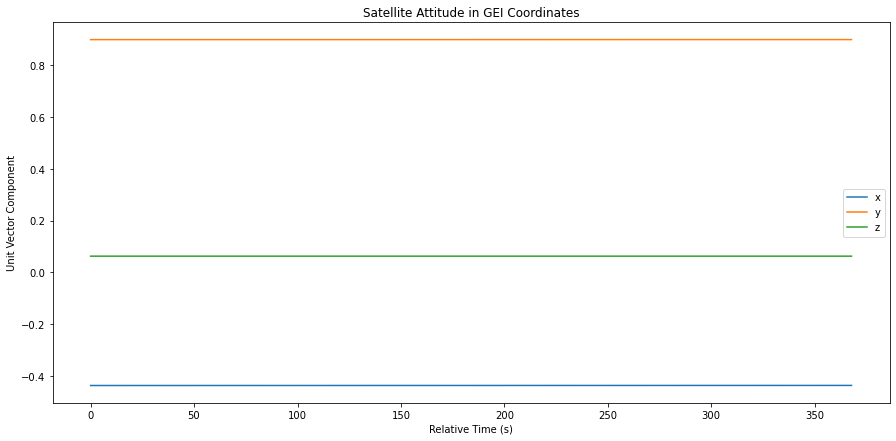

In [30]:
fig, ax = plt.subplots(1, figsize = (15, 7))

ax.plot(ctime, att_GEI_x, label='x')
ax.plot(ctime, att_GEI_y, label='y')
ax.plot(ctime, att_GEI_z, label='z')

ax.set_title('Satellite Attitude in GEI Coordinates')
ax.set_xlabel('Relative Time (s)')
ax.set_ylabel('Unit Vector Component')
ax.legend()

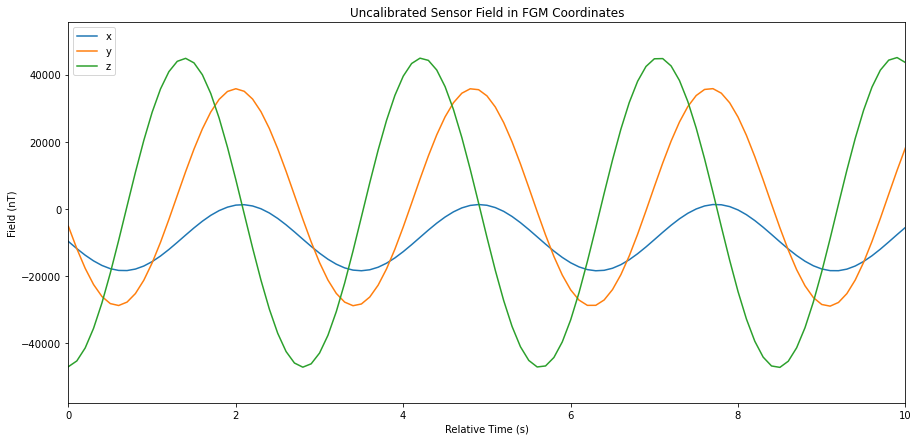

In [31]:
fig, ax = plt.subplots(1, figsize = (15, 7))

ax.plot(ctime, B_raw_FGM_x, label='x')
ax.plot(ctime, B_raw_FGM_y, label='y')
ax.plot(ctime, B_raw_FGM_z, label='z')

ax.set_title('Uncalibrated Sensor Field in FGM Coordinates')
ax.set_xlabel('Relative Time (s)')
ax.set_ylabel('Field (nT)')
ax.set_xlim(0, 10)
ax.legend()

In [32]:
B_hat_IGRF_GEI_x = B_IGRF_GEI_x/np.sqrt(B_IGRF_GEI_x**2 + B_IGRF_GEI_y**2 + B_IGRF_GEI_z**2)
B_hat_IGRF_GEI_y = B_IGRF_GEI_y/np.sqrt(B_IGRF_GEI_x**2 + B_IGRF_GEI_y**2 + B_IGRF_GEI_z**2)
B_hat_IGRF_GEI_z = B_IGRF_GEI_z/np.sqrt(B_IGRF_GEI_x**2 + B_IGRF_GEI_y**2 + B_IGRF_GEI_z**2)

In [33]:
DMXL_2_GEI = np.zeros((len(ctime), 3, 3))

In [34]:
for i in range(len(ctime)):
    
    u_hat = np.array([att_GEI_x[i], att_GEI_y[i], att_GEI_z[i]])
    b_hat = np.array([B_hat_IGRF_GEI_x[i], B_hat_IGRF_GEI_y[i], B_hat_IGRF_GEI_z[i]])
    
    DMXL_2_GEI[i,:,0] = np.cross(b_hat, u_hat)
    DMXL_2_GEI[i,:,1] = np.cross(u_hat, np.cross(b_hat, u_hat))
    DMXL_2_GEI[i,:,2] = u_hat
    
    DMXL_2_GEI[i,:,0] /= np.linalg.norm(DMXL_2_GEI[i,:,0])
    DMXL_2_GEI[i,:,1] /= np.linalg.norm(DMXL_2_GEI[i,:,1])
    DMXL_2_GEI[i,:,2] /= np.linalg.norm(DMXL_2_GEI[i,:,2]) 

In [35]:
B_IGRF_DMXL_x = np.zeros(len(ctime))
B_IGRF_DMXL_y = np.zeros(len(ctime))
B_IGRF_DMXL_z = np.zeros(len(ctime))

for i in range(len(ctime)):
    
    GEI_2_DMXL = np.linalg.inv(DMXL_2_GEI[i])
    
    B_IGRF_DMXL_x[i] = GEI_2_DMXL[0,0]*B_IGRF_GEI_x[i] + GEI_2_DMXL[0,1]*B_IGRF_GEI_y[i] + GEI_2_DMXL[0,2]*B_IGRF_GEI_z[i]
    B_IGRF_DMXL_y[i] = GEI_2_DMXL[1,0]*B_IGRF_GEI_x[i] + GEI_2_DMXL[1,1]*B_IGRF_GEI_y[i] + GEI_2_DMXL[1,2]*B_IGRF_GEI_z[i]
    B_IGRF_DMXL_z[i] = GEI_2_DMXL[2,0]*B_IGRF_GEI_x[i] + GEI_2_DMXL[2,1]*B_IGRF_GEI_y[i] + GEI_2_DMXL[2,2]*B_IGRF_GEI_z[i]    

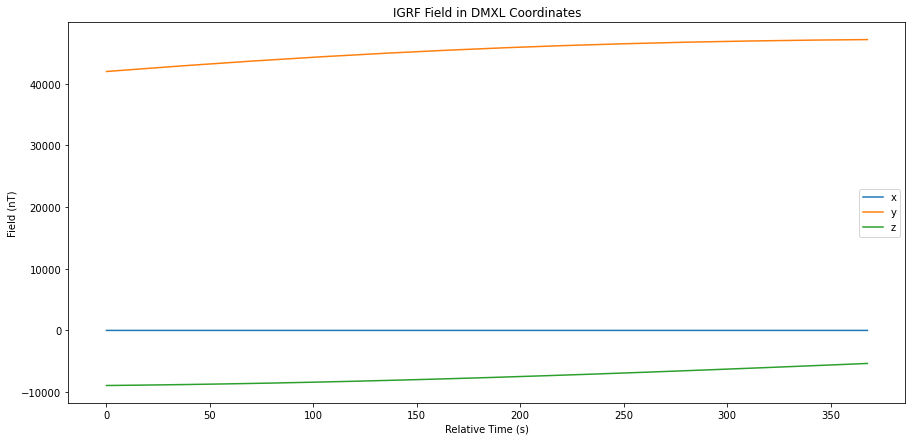

In [36]:
fig, ax = plt.subplots(1, figsize = (15, 7))

ax.plot(ctime, B_IGRF_DMXL_x, label='x')
ax.plot(ctime, B_IGRF_DMXL_y, label='y')
ax.plot(ctime, B_IGRF_DMXL_z, label='z')

ax.set_title('IGRF Field in DMXL Coordinates')
ax.set_xlabel('Relative Time (s)')
ax.set_ylabel('Field (nT)')
ax.legend()

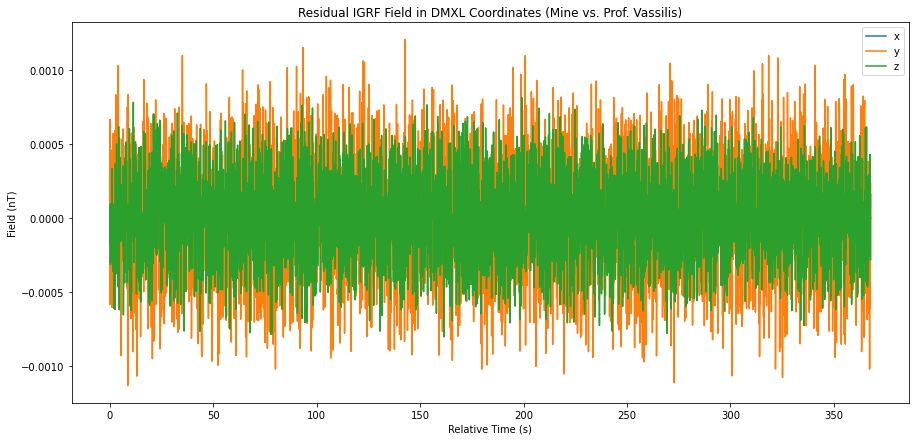

In [37]:
fig, ax = plt.subplots(1, figsize = (15, 7))

ax.plot(ctime, B_IGRF_DMXL_x-B_IGRF_DMXL_x_load, label='x')
ax.plot(ctime, B_IGRF_DMXL_y-B_IGRF_DMXL_y_load, label='y')
ax.plot(ctime, B_IGRF_DMXL_z-B_IGRF_DMXL_z_load, label='z')

ax.set_title('Residual IGRF Field in DMXL Coordinates (Mine vs. Prof. Vassilis)')
ax.set_xlabel('Relative Time (s)')
ax.set_ylabel('Field (nT)')
ax.legend()